In [2]:
# imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# load data
from pathlib import Path

# data directory
DATA = Path("../data")

# Load EEG segments labeled
eeg = pd.read_csv(DATA / "eeg_segments_labeled.csv")

# Load session summary labeled
sessions = pd.read_csv(DATA / "session_summary_labeled.csv")

# Quick look at data
display(eeg.head())
display(sessions.head())


,subject_id,session_id,segment_idx,timestamp,alpha_power,beta_power,theta_power,gamma_power,disengaged
0,S001,U8KXB4N9,0,2025-04-01 14:00:00,1.5964,0.9354,1.3620,0.9980,1
1,S001,U8KXB4N9,1,2025-04-01 14:00:10,0.9799,0.9322,1.4147,0.7717,1
2,S001,U8KXB4N9,2,2025-04-01 14:00:20,1.4633,0.7045,1.6506,1.0507,1
3,S001,U8KXB4N9,4,2025-04-01 14:00:40,1.1389,0.8947,0.8671,0.2875,1
4,S001,U8KXB4N9,6,2025-04-01 14:01:00,1.3752,0.8834,1.1537,0.5461,1


,subject_id,session_id,stimulus_type,task_difficulty,modality,start_time,end_time,n_segments,mean_cog_load,pct_engaged,mean_disengage_risk,disengaged
0,S001,U8KXB4N9,Discussion,Easy,Live Workshop,2025-04-01 14:00:00,2025-04-01 14:10:10,62,0.290,46.8,0.466,1
1,S002,U5HKN6BB,Hands-on Lab,Moderate,Async Video,2025-02-10 14:00:00,2025-02-10 14:05:50,36,0.269,66.7,0.347,0
2,S005,UOWZ6RUE,Lecture,Moderate,Async Video,2025-01-16 14:00:00,2025-01-16 14:06:00,37,0.284,62.2,0.410,1
3,S006,U56BXK8B,Discussion,Moderate,Self-Paced,2025-02-18 13:00:00,2025-02-18 13:05:10,32,0.270,59.4,0.422,1
4,S007,U0L23F7L,Code-Along,Moderate,Async Video,2025-03-21 15:00:00,2025-03-21 15:19:00,115,0.280,66.1,0.373,0


In [4]:
# Merge session info into eeg data
sessions_safe = sessions[["session_id", "stimulus_type", "task_difficulty", "modality"]]  # select safe features
df = eeg.merge(sessions_safe, on="session_id", how="left")
df.head()


,subject_id,session_id,segment_idx,timestamp,alpha_power,beta_power,theta_power,gamma_power,disengaged,stimulus_type,task_difficulty,modality
0,S001,U8KXB4N9,0,2025-04-01 14:00:00,1.5964,0.9354,1.3620,0.9980,1,Discussion,Easy,Live Workshop
1,S001,U8KXB4N9,1,2025-04-01 14:00:10,0.9799,0.9322,1.4147,0.7717,1,Discussion,Easy,Live Workshop
2,S001,U8KXB4N9,2,2025-04-01 14:00:20,1.4633,0.7045,1.6506,1.0507,1,Discussion,Easy,Live Workshop
3,S001,U8KXB4N9,4,2025-04-01 14:00:40,1.1389,0.8947,0.8671,0.2875,1,Discussion,Easy,Live Workshop
4,S001,U8KXB4N9,6,2025-04-01 14:01:00,1.3752,0.8834,1.1537,0.5461,1,Discussion,Easy,Live Workshop


In [5]:
# Define features and target
eeg_features = ["alpha_power", "beta_power", "theta_power", "gamma_power"]  # numeric
categorical_features = ["stimulus_type", "task_difficulty", "modality"]  # categorical
X = df[eeg_features + categorical_features]  # features
y = df["disengaged"].values  # target
groups = df["subject_id"].values  # for GroupKFold


In [6]:
# Train-test split with stratification and grouping
SEED = 42
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=SEED, stratify=y
)


In [7]:
# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), eeg_features),  # scale numeric
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)  # encode categorical
    ]
)


In [8]:
# threshold selection function
def choose_threshold_max_f1(y_true, proba):
    from sklearn.metrics import precision_recall_curve
    p, r, t = precision_recall_curve(y_true, proba)
    if len(t) == 0:
        return 0.5
    f1 = (2 * p * r) / np.clip(p + r, 1e-9, None)
    return float(t[np.nanargmax(f1[:-1])])


In [9]:
# confusion matrix and metrics display function
def show_confusion_and_explain(model_name, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index=["Actual 1 (disengaged)", "Actual 0 (engaged)"],
                         columns=["Pred 1 (disengaged)", "Pred 0 (engaged)"])
    display(df_cm)
    TP, FN = cm[0, 0], cm[0, 1]; FP, TN = cm[1, 0], cm[1, 1]
    prec = TP / (TP + FP + 1e-9); rec = TP / (TP + FN + 1e-9)
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(f"{model_name} → Precision={prec:.3f}, Recall={rec:.3f}, Accuracy={acc:.3f}")


In [10]:
# train and evaluate function
experiment_log = []

def train_and_evaluate(model, name, X_train, X_test, y_train, y_test, groups_train):
    cv = GroupKFold(n_splits=5)  # group split by subject
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])  # pipeline
    oof = cross_val_predict(pipe, X_train, y_train, groups=groups_train, cv=cv,
                            method="predict_proba", n_jobs=-1)[:, 1]  # OOF probabilities
    thr = choose_threshold_max_f1(y_train, oof)  # select threshold
    pipe.fit(X_train, y_train)  # train model
    proba_test = pipe.predict_proba(X_test)[:, 1]  # test probabilities
    acc = accuracy_score(y_test, (proba_test >= thr).astype(int))
    prec = precision_score(y_test, (proba_test >= thr).astype(int))
    rec = recall_score(y_test, (proba_test >= thr).astype(int))
    f1 = f1_score(y_test, (proba_test >= thr).astype(int))
    print(f"\n{name} Results: Accuracy: {acc*100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    show_confusion_and_explain(name, y_test, proba_test, thr)
    experiment_log.append({"Model": name, "Accuracy": round(acc, 3), "Precision": round(prec, 3),
                           "Recall": round(rec, 3), "F1": round(f1, 3), "Thr": round(thr, 3)})
    return pipe, thr, proba_test


In [11]:
# define models
lr_model = LogisticRegression(max_iter=5000, random_state=SEED, class_weight="balanced")
dt_model = DecisionTreeClassifier(max_depth=12, min_samples_split=5, random_state=SEED, class_weight="balanced")
rf_model = RandomForestClassifier(n_estimators=500, max_depth=14, min_samples_leaf=3,
                                  random_state=SEED, n_jobs=-1, class_weight="balanced")


In [12]:
# train and evaluate models
pipe_rf, thr_rf, proba_test_rf = train_and_evaluate(rf_model, "Random Forest",
                                                    X_train, X_test, y_train, y_test, groups_train)
pipe_dt, thr_dt, proba_test_dt = train_and_evaluate(dt_model, "Decision Tree",
                                                    X_train, X_test, y_train, y_test, groups_train)
pipe_lr, thr_lr, proba_test_lr = train_and_evaluate(lr_model, "Logistic Regression",
                                                    X_train, X_test, y_train, y_test, groups_train)



Random Forest Results: Accuracy: 84.87% | Precision: 0.776 | Recall: 0.983 | F1: 0.867


,Pred 1 (disengaged),Pred 0 (engaged)
Actual 1 (disengaged),409,7
Actual 0 (engaged),118,292


Random Forest → Precision=0.776, Recall=0.983, Accuracy=0.849

Decision Tree Results: Accuracy: 86.68% | Precision: 0.831 | Recall: 0.923 | F1: 0.875


,Pred 1 (disengaged),Pred 0 (engaged)
Actual 1 (disengaged),384,32
Actual 0 (engaged),78,332


Decision Tree → Precision=0.831, Recall=0.923, Accuracy=0.867

Logistic Regression Results: Accuracy: 81.72% | Precision: 0.790 | Recall: 0.868 | F1: 0.827


,Pred 1 (disengaged),Pred 0 (engaged)
Actual 1 (disengaged),361,55
Actual 0 (engaged),96,314


Logistic Regression → Precision=0.790, Recall=0.868, Accuracy=0.817


In [13]:
# summary of results
df_results = pd.DataFrame(experiment_log).sort_values("Accuracy", ascending=False).reset_index(drop=True)
display(df_results)
print(f"Best by Accuracy: {df_results.iloc[0]['Model']} ({df_results.iloc[0]['Accuracy']*100:.2f}%)")


,Model,Accuracy,Precision,Recall,F1,Thr
0,Decision Tree,0.867,0.831,0.923,0.875,0.059
1,Random Forest,0.849,0.776,0.983,0.867,0.143
2,Logistic Regression,0.817,0.790,0.868,0.827,0.443


Best by Accuracy: Decision Tree (86.70%)


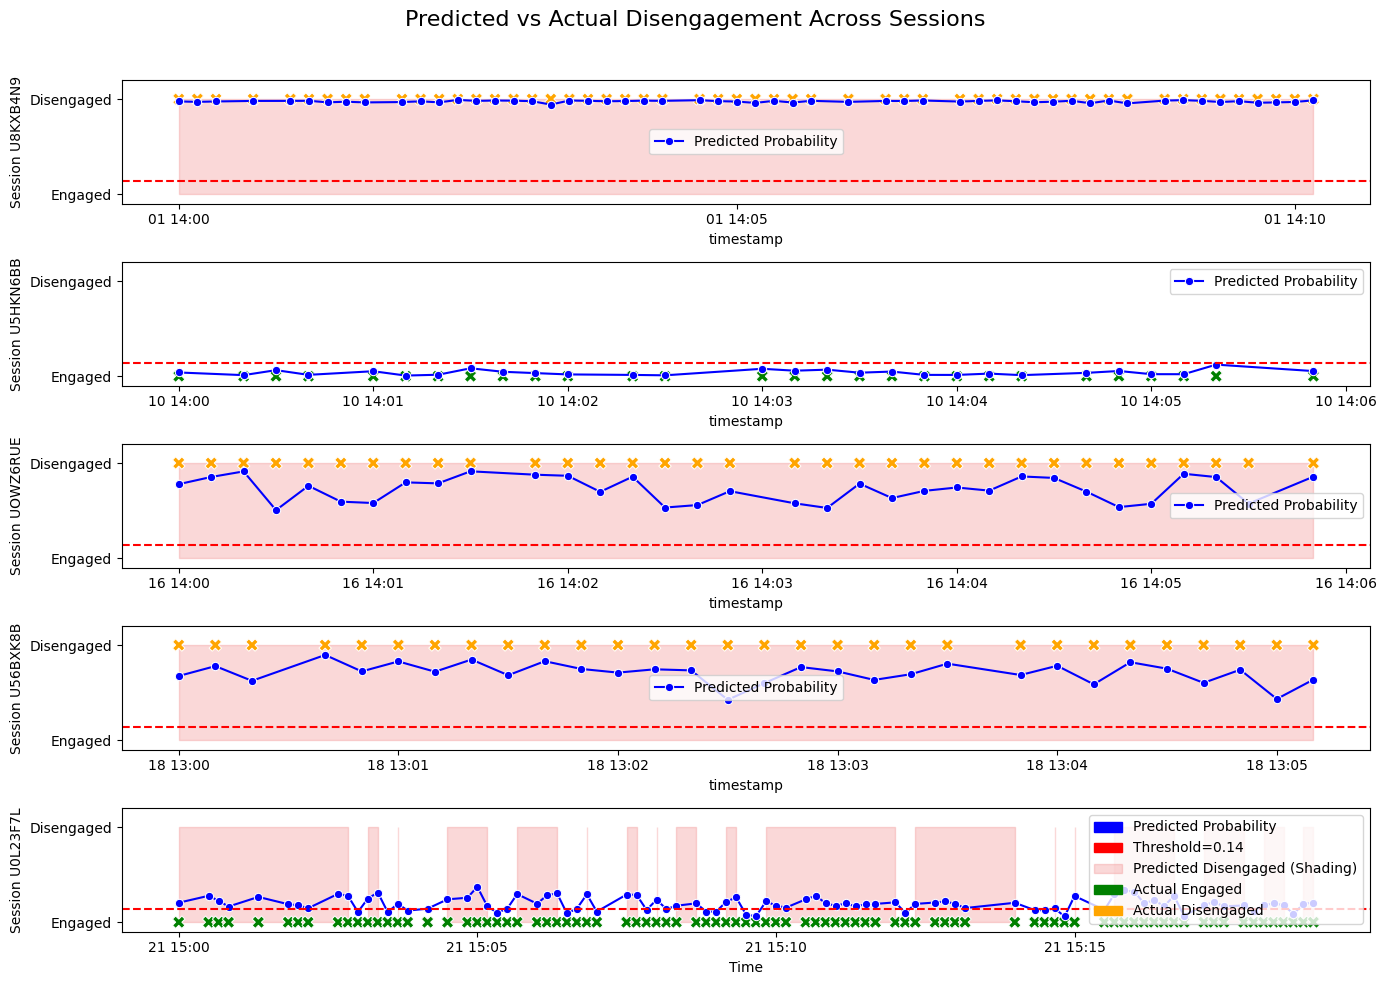

In [14]:
# disengagment overview across multiple sessions
import matplotlib.patches as mpatches  # for custom legend handles

# Select first 5 sessions
session_ids = df['session_id'].unique()[:5]
plt.figure(figsize=(14, 2 * len(session_ids)))

for i, sess_id in enumerate(session_ids):
    
    # Filter session data
    df_sess = df[df['session_id'] == sess_id].copy()
    df_sess['timestamp'] = pd.to_datetime(df_sess['timestamp'])
    
    # Prepare features for prediction
    X_sess = df_sess[eeg_features + categorical_features]
    
    # Predict disengagement probabilities
    df_sess['predicted_proba'] = pipe_rf.predict_proba(X_sess)[:, 1]
    
    # Map numeric disengagement to labels
    df_sess['disengaged_label'] = df_sess['disengaged'].map({0: 'Engaged', 1: 'Disengaged'})
    
    # Create subplot for session
    plt.subplot(len(session_ids), 1, i+1)
    
    # Plot predicted probability line
    sns.lineplot(x='timestamp', y='predicted_proba', data=df_sess, marker='o',
                 label='Predicted Probability', color='blue')
    
    # Shade predicted disengaged periods
    plt.fill_between(df_sess['timestamp'], 0, 1, where=(df_sess['predicted_proba'] >= thr_rf),
                     color='lightcoral', alpha=0.3)
    
    # Scatter actual disengagement markers (numeric y, colored by label)
    sns.scatterplot(x='timestamp', y=df_sess['disengaged'], data=df_sess,
                    s=80, marker='X',
                    color=df_sess['disengaged'].map({0:'green', 1:'orange'}))
    
    # Threshold line
    plt.axhline(thr_rf, color='red', linestyle='--', label=f'Threshold={thr_rf:.2f}')
    
    # Common y-axis for all subplots
    plt.yticks([0, 1], ['Engaged', 'Disengaged'])
    plt.ylim(-0.1, 1.2)
    plt.ylabel(f"Session {sess_id}")

# legends
pred_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='Predicted Disengaged (Shading)')
engaged_patch = mpatches.Patch(color='green', label='Actual Engaged')
disengaged_patch = mpatches.Patch(color='orange', label='Actual Disengaged')
prob_line = mpatches.Patch(color='blue', label='Predicted Probability')
threshold_line = mpatches.Patch(color='red', label=f'Threshold={thr_rf:.2f}')

plt.legend(handles=[prob_line, threshold_line, pred_patch, engaged_patch, disengaged_patch],
           loc='upper right')

plt.xlabel("Time")
plt.suptitle("Predicted vs Actual Disengagement Across Sessions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold

cv = GroupKFold(n_splits=5)

# ---- Decision Tree: focused grid (fast + strong) ----
dt_param_grid = {
    "model__max_depth": [6, 8, 10, 12, None],
    "model__min_samples_split": [2, 3, 5, 10],
    "model__min_samples_leaf": [1, 2, 3, 4],
    "model__criterion": ["gini", "entropy"]
}

dt_pipe = Pipeline([("preprocess", preprocessor),
                    ("model", DecisionTreeClassifier(random_state=SEED, class_weight="balanced"))])

dt_search = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    cv=cv,                      # pass the splitter
    scoring="accuracy",         # or "balanced_accuracy" / "f1"
    n_jobs=-1,
    verbose=1
)
dt_search.fit(X_train, y_train, model__sample_weight=None, groups=groups_train)  # pass groups here

print("DT best params:", dt_search.best_params_)
print("DT best CV acc:", dt_search.best_score_)
best_dt_pipe = dt_search.best_estimator_


Fitting 5 folds for each of 160 candidates, totalling 800 fits
DT best params: {'model__criterion': 'entropy', 'model__max_depth': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
DT best CV acc: 0.7271060299353101


In [16]:
# ---- Random Forest: broader randomized search (then optionally a small grid refine) ----
rf_param_dist = {
    "model__n_estimators": [200, 400, 600, 800, 1200],
    "model__max_depth": [8, 10, 12, 14, 16, None],
    "model__min_samples_split": [2, 3, 5, 10],
    "model__min_samples_leaf": [1, 2, 3, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True]
}

rf_pipe = Pipeline([("preprocess", preprocessor),
                    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced"))])

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=40,                  # adjust if you want faster/slower
    cv=cv,
    scoring="accuracy",         # or "balanced_accuracy" / "f1"
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)
rf_search.fit(X_train, y_train, groups=groups_train)

print("RF best params:", rf_search.best_params_)
print("RF best CV acc:", rf_search.best_score_)
best_rf_pipe = rf_search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
RF best params: {'model__n_estimators': 800, 'model__min_samples_split': 3, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 8, 'model__bootstrap': True}
RF best CV acc: 0.6902747238363788


In [18]:
from sklearn.model_selection import cross_val_predict

def eval_pipe_with_threshold(name, pipe):
    # OOF probs for threshold selection
    oof = cross_val_predict(
        pipe, X_train, y_train,
        groups=groups_train,
        cv=GroupKFold(5),
        method="predict_proba",
        n_jobs=-1
    )[:, 1]
    thr = choose_threshold_max_f1(y_train, oof)

    # Fit and evaluate on held-out test
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    yhat = (proba >= thr).astype(int)

    acc  = accuracy_score(y_test, yhat)
    prec = precision_score(y_test, yhat, zero_division=0)
    rec  = recall_score(y_test, yhat)
    f1   = f1_score(y_test, yhat)

    print(f"\n{name} (tuned): Acc {acc*100:.2f}% | Prec {prec:.3f} | Rec {rec:.3f} | F1 {f1:.3f} | Thr {thr:.3f}")
    show_confusion_and_explain(name, y_test, proba, thr)

    experiment_log.append({"Model": name+" (tuned)", "Accuracy": round(acc,3),
                           "Precision": round(prec,3), "Recall": round(rec,3),
                           "F1": round(f1,3), "Thr": round(thr,3)})

    return pipe, thr

best_dt_pipe, thr_dt_tuned = eval_pipe_with_threshold("Decision Tree", best_dt_pipe)
best_rf_pipe, thr_rf_tuned = eval_pipe_with_threshold("Random Forest", best_rf_pipe)

pd.DataFrame(experiment_log).sort_values("Accuracy", ascending=False).reset_index(drop=True)



Decision Tree (tuned): Acc 86.08% | Prec 0.807 | Rec 0.952 | F1 0.873 | Thr 0.281


,Pred 1 (disengaged),Pred 0 (engaged)
Actual 1 (disengaged),396,20
Actual 0 (engaged),95,315


Decision Tree → Precision=0.807, Recall=0.952, Accuracy=0.861

Random Forest (tuned): Acc 85.47% | Prec 0.787 | Rec 0.976 | F1 0.871 | Thr 0.232


,Pred 1 (disengaged),Pred 0 (engaged)
Actual 1 (disengaged),406,10
Actual 0 (engaged),110,300


Random Forest → Precision=0.787, Recall=0.976, Accuracy=0.855


,Model,Accuracy,Precision,Recall,F1,Thr
0,Decision Tree,0.867,0.831,0.923,0.875,0.059
1,Decision Tree (tuned),0.861,0.807,0.952,0.873,0.281
2,Decision Tree (tuned),0.861,0.807,0.952,0.873,0.281
3,Random Forest (tuned),0.855,0.787,0.976,0.871,0.232
4,Random Forest (tuned),0.855,0.787,0.976,0.871,0.232
5,Random Forest,0.849,0.776,0.983,0.867,0.143
6,Logistic Regression,0.817,0.790,0.868,0.827,0.443


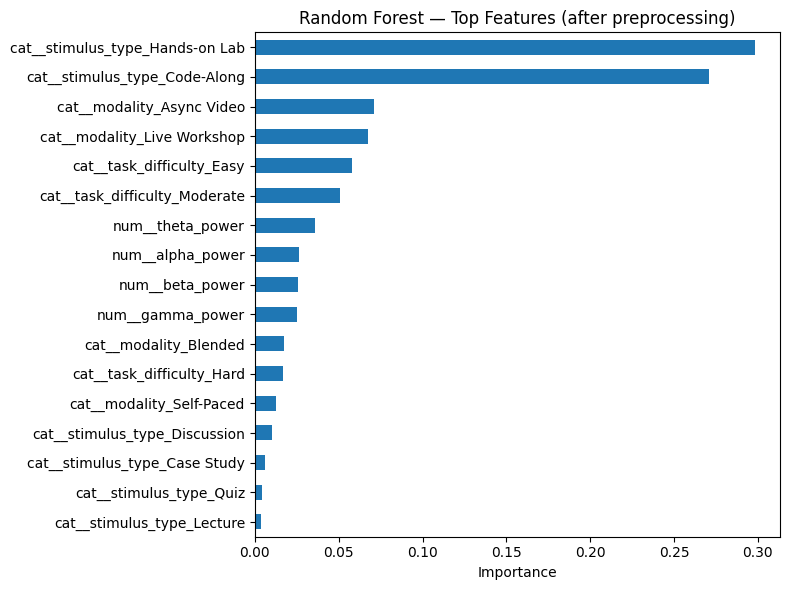

In [19]:
# Get transformed feature names from the ColumnTransformer
# This requires sklearn >= 1.0 for get_feature_names_out
X_cols = X_train.columns
feat_names = best_rf_pipe.named_steps["preprocess"].get_feature_names_out(X_cols)

# Pull importances from the tree model
rf_est = best_rf_pipe.named_steps["model"]   # RandomForestClassifier
importances = pd.Series(rf_est.feature_importances_, index=feat_names).sort_values(ascending=False)

# Top features plot
import matplotlib.pyplot as plt
topN = 20
importances.head(topN).sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Random Forest — Top Features (after preprocessing)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()


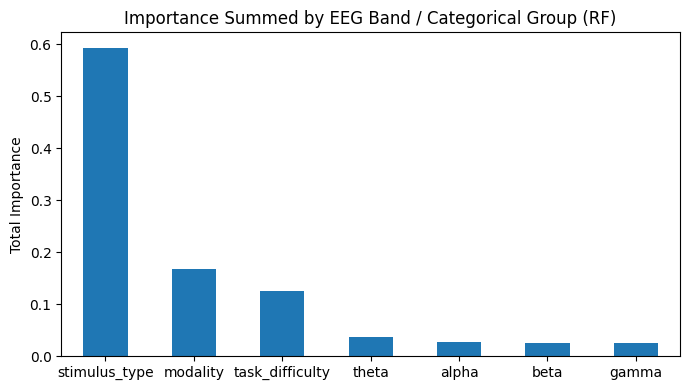

stimulus_type      0.593423
modality           0.168401
task_difficulty    0.124819
theta              0.035956
alpha              0.026460
beta               0.025923
gamma              0.025019
dtype: float64

In [20]:
def band_bucket(transformed_name: str):
    s = transformed_name.lower()
    # numeric features (prefixed by "num__")
    if "num__alpha_power" in s: return "alpha"
    if "num__beta_power"  in s: return "beta"
    if "num__theta_power" in s: return "theta"
    if "num__gamma_power" in s: return "gamma"
    # categorical (prefixed by "cat__")
    if "cat__stimulus_type_" in s:  return "stimulus_type"
    if "cat__task_difficulty_" in s:return "task_difficulty"
    if "cat__modality_" in s:       return "modality"
    return "other"

band_importance = importances.groupby(band_bucket).sum().sort_values(ascending=False)
ax = band_importance.plot(kind="bar", rot=0, figsize=(7,4))
ax.set_title("Importance Summed by EEG Band / Categorical Group (RF)")
ax.set_ylabel("Total Importance")
plt.tight_layout(); plt.show()

band_importance


In [22]:
leaderboard = pd.DataFrame(experiment_log).sort_values("Accuracy", ascending=False).reset_index(drop=True)
display(leaderboard)
print(f"Best by Accuracy: {leaderboard.iloc[0]['Model']} ({leaderboard.iloc[0]['Accuracy']*100:.2f}%)")


,Model,Accuracy,Precision,Recall,F1,Thr
0,Decision Tree,0.867,0.831,0.923,0.875,0.059
1,Decision Tree (tuned),0.861,0.807,0.952,0.873,0.281
2,Decision Tree (tuned),0.861,0.807,0.952,0.873,0.281
3,Random Forest (tuned),0.855,0.787,0.976,0.871,0.232
4,Random Forest (tuned),0.855,0.787,0.976,0.871,0.232
5,Random Forest,0.849,0.776,0.983,0.867,0.143
6,Logistic Regression,0.817,0.790,0.868,0.827,0.443


Best by Accuracy: Decision Tree (86.70%)
